In [8]:
import numpy as np
import pandas as pd
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [9]:
df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,
                            "uciml/breast-cancer-wisconsin-data",
                            "data.csv" )

print(df.shape)

(569, 33)


In [10]:
y = df["diagnosis"].map({"M": 1, "B": 0}).values

# drop non-feature columns
X_raw = df.drop(columns=["id", "diagnosis", "Unnamed: 32"], errors="ignore").values

if np.isnan(X_raw).any():
    print("Missing values detected. Imputing with column means...")
    # Calculate mean of each column ignoring NaNs
    col_mean = np.nanmean(X_raw, axis=0)
    
    # Find indices where values are NaN
    inds = np.where(np.isnan(X_raw))
    
    # Replace NaNs with the corresponding column mean
    X_raw[inds] = np.take(col_mean, inds[1])
else:
    print("No missing values found.")
# standardize features
scaler = StandardScaler()
x = scaler.fit_transform(X_raw)

print(x.shape)  

No missing values found.
(569, 30)


In [11]:
class K_means:
    def __init__(self, k, init, max_itrns=100, tolerance=1e-4, random_state=None):
        self.k = k
        self.init = init
        self.max_itrns = max_itrns
        self.tolerance = tolerance
        self.random_state = random_state
        self.centroids = None
        self.labels = None
        self.inertia_history = []
    
    def _init_random(self, x):
        num_of_samples = x.shape[0] # rows
        indices = np.random.choice(num_of_samples, size=self.k, replace=False)
        return  x[indices]
    
    def _init_Kpp(self, x):
        num_of_samples = x.shape[0] # rows
        index = np.random.randint(num_of_samples) # only one sample
        centroids = []
        centroids.append(x[index])

        for _ in range(1, self.k):
            dists_sq = np.min(
                    [np.sum((x - c) ** 2, axis=1) for c in centroids],
                    axis=0
                ) # for each point in x:
                # compute distance to every centroid
                # keep the smallest one
            probs = dists_sq / np.sum(dists_sq)
            index = np.random.choice(num_of_samples, p=probs) 
            centroids.append(x[index])

        return np.array(centroids)

    def assign_clusters(self, x):
        distances = np.linalg.norm(x[:, None] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

    def compute_centroids(self, x):
        new_centroids = np.array([
            x[self.labels == i].mean(axis=0)
            if i in self.labels
            else self.centroids[i]  # handle empty cluster
            for i in range(self.k)
        ])
        return new_centroids

    def compute_inertia(self, x):
        return np.sum((x - self.centroids[self.labels]) ** 2)
    
    def fit(self, x):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        if self.init == "random":
            self.centroids = self._init_random(x)
        elif self.init == "kmeans++":
            self.centroids = self._init_Kpp(x)
        else:
            raise ValueError("init must be 'random' or 'kmeans++'")

        for _ in range(self.max_itrns):
            self.labels = self.assign_clusters(x)
            inertia = self.compute_inertia(x)
            self.inertia_history.append(inertia)

            new_centroids = self.compute_centroids(x)

            # tolerance-based convergence
            shift = np.linalg.norm(self.centroids - new_centroids)
            if shift < self.tolerance:
                break

            self.centroids = new_centroids
        return self

    def predict(self, x):
        return self.assign_clusters(x)

PCA Explained Variance Ratio: [0.44272026 0.18971182]
PCA Reconstruction Error (MSE): 0.36757


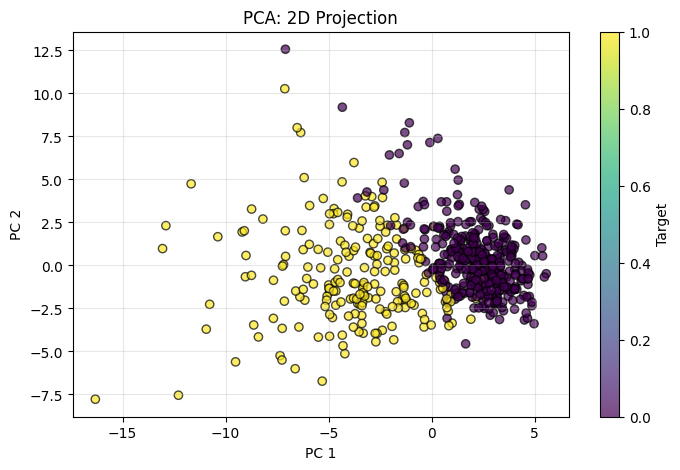

In [12]:
class PCA_Manual:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None
        self.explained_variance_ratio = None
        
    def fit(self, X):
        # 1. Center the data
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        
        # 2. Compute Covariance Matrix
        # Unbiased estimator (n-1)
        n_samples = X.shape[0]
        cov_matrix = np.dot(X_centered.T, X_centered) / (n_samples - 1)
        
        # 3. Eigen Decomposition
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        # 4. Sort by eigenvalues (descending)
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # 5. Store results
        self.components = eigenvectors[:, :self.n_components]
        total_variance = np.sum(eigenvalues)
        self.explained_variance_ratio = eigenvalues[:self.n_components] / total_variance
        
    def transform(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)
    
    def inverse_transform(self, X_transformed):
        return np.dot(X_transformed, self.components.T) + self.mean
    
    def reconstruction_error(self, X):
        X_pca = self.transform(X)
        X_recon = self.inverse_transform(X_pca)
        return np.mean((X - X_recon) ** 2)

# --- Execute PCA ---
pca = PCA_Manual(n_components=2)
pca.fit(x)
X_pca = pca.transform(x)

print(f"PCA Explained Variance Ratio: {pca.explained_variance_ratio}")
print(f"PCA Reconstruction Error (MSE): {pca.reconstruction_error(x):.5f}")
# Visualization
plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
plt.title('PCA: 2D Projection')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar(label='Target')
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
%run ./Metrics.ipynb

# Comp     | Recon Err  | Sil (Int)  | ARI (Ext) 
--------------------------------------------------
2          | 0.3676     | 0.5085     | 0.6592
5          | 0.1527     | 0.3919     | 0.6536
10         | 0.0484     | 0.3565     | 0.6536
15         | 0.0135     | 0.3461     | 0.6594
20         | 0.0044     | 0.3438     | 0.6594


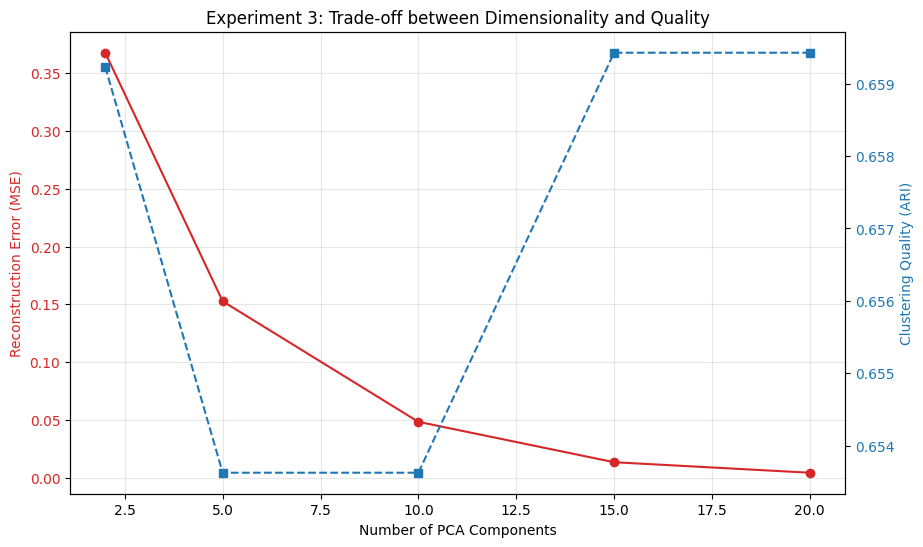

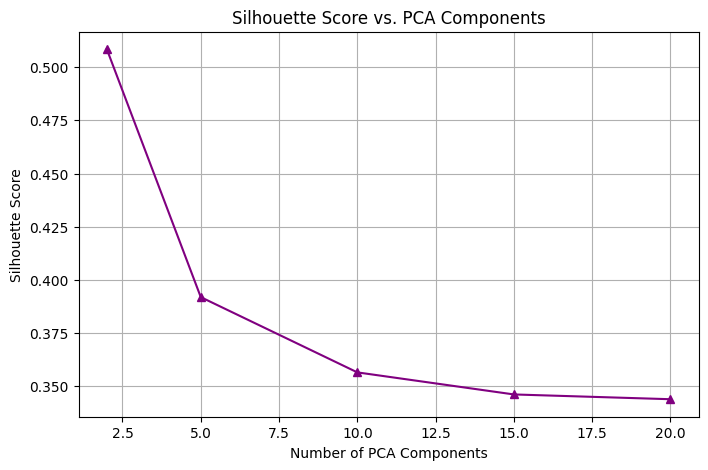

In [14]:

component_counts = [2, 5, 10, 15, 20]

# Storage for results
results = {
    'components': [],
    'recon_error': [],
    'silhouette': [],
    'db_index': [],
    'ch_index': [],
    'ari': [],
    'nmi': [],
    'purity': []
}

print(f"{'# Comp':<10} | {'Recon Err':<10} | {'Sil (Int)':<10} | {'ARI (Ext)':<10}")
print("-" * 50)

for n in component_counts:
    # 1. Apply Your PCA
    pca = PCA_Manual(n_components=n)
    pca.fit(x)  # Using 'x' from your preprocessing
    X_pca = pca.transform(x)
    
    # 2. Compute Reconstruction Error
    rec_err = pca.reconstruction_error(x)
    
    # 3. Apply Your K-Means
    # Using k=2 because Breast Cancer target 'y' has 2 classes (M/B)
    kmeans_model = K_means(k=2, init='kmeans++', max_itrns=100, random_state=42)
    kmeans_model.fit(X_pca)
    
    labels = kmeans_model.labels
    
    # 4. Compute Metrics (USING MANUAL FUNCTIONS)
    
    # Internal Validation
    sil = silhouette_score_manual(X_pca, labels)
    db = davies_bouldin_manual(X_pca, labels)
    ch = calinski_harabasz_manual(X_pca, labels)
    
    # External Validation (comparing to 'y' from preprocessing)
    ari = adjusted_rand_index_manual(y, labels)
    nmi = nmi_manual(y, labels)
    pur = purity_score_manual(y, labels)
    
    # Store Data
    results['components'].append(n)
    results['recon_error'].append(rec_err)
    results['silhouette'].append(sil)
    results['db_index'].append(db)
    results['ch_index'].append(ch)
    results['ari'].append(ari)
    results['nmi'].append(nmi)
    results['purity'].append(pur)
    
    print(f"{n:<10} | {rec_err:.4f}     | {sil:.4f}     | {ari:.4f}")

# Visualization

# Plot 1: Trade-off (Reconstruction Error vs Clustering Quality)
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Number of PCA Components')
ax1.set_ylabel('Reconstruction Error (MSE)', color=color)
ax1.plot(results['components'], results['recon_error'], color=color, marker='o', label='Recon Error')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Twin axis for Clustering Quality (using ARI as the representative external metric)
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Clustering Quality (ARI)', color=color)
ax2.plot(results['components'], results['ari'], color=color, marker='s', linestyle='--', label='ARI')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Experiment 3: Trade-off between Dimensionality and Quality')
plt.show()

# Plot 2: Internal Metric (Silhouette Score)
plt.figure(figsize=(8, 5))
plt.plot(results['components'], results['silhouette'], marker='^', color='purple', linestyle='-')
plt.title('Silhouette Score vs. PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

--- Visualizing Best Result (n=2) ---


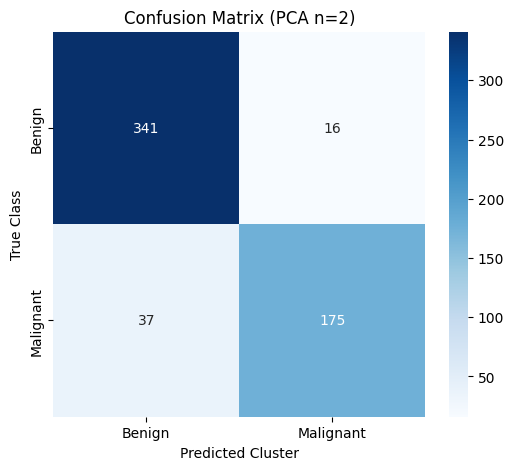

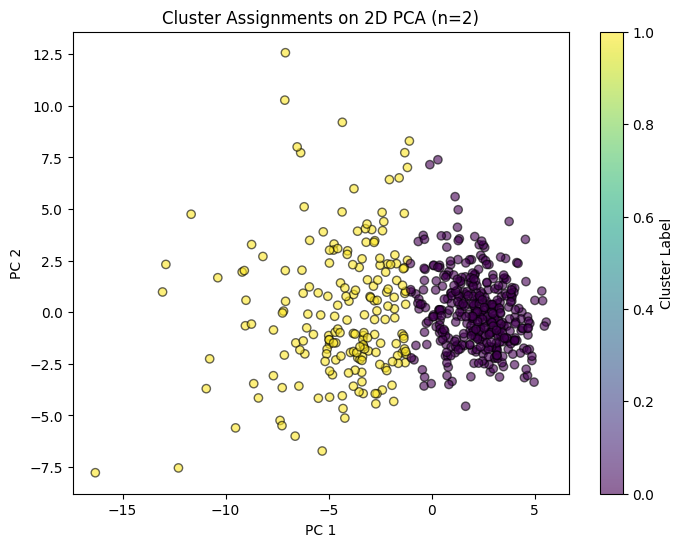

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Select Best Model 
best_n = 2
print(f"--- Visualizing Best Result (n={best_n}) ---")

# 1. Re-run for the best N
pca_best = PCA_Manual(n_components=best_n)
pca_best.fit(x)
X_best = pca_best.transform(x)

kmeans_best = K_means(k=2, init='kmeans++', max_itrns=100, random_state=42)
kmeans_best.fit(X_best)
preds_best = kmeans_best.labels

# 2. Plot Confusion Matrix
cm = confusion_matrix(y, preds_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title(f'Confusion Matrix (PCA n={best_n})')
plt.xlabel('Predicted Cluster')
plt.ylabel('True Class')
plt.show()

# 3. Plot 2D Projection with Cluster Colors
plt.figure(figsize=(8, 6))
# If n > 2, we just take the first 2 columns for plotting
plt.scatter(X_best[:, 0], X_best[:, 1], c=preds_best, cmap='viridis', edgecolor='k', alpha=0.6)
plt.title(f'Cluster Assignments on 2D PCA (n={best_n})')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar(label='Cluster Label')
plt.show()